scTree usage example
====================

This example follows the [palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb). Doing palantir diffusion maps is usually a good pre-preprocessing step before using elpigraph or ppt.

## Importing modules and basic settings

In [7]:
from anndata import AnnData
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import palantir
import scFates as scf
%matplotlib inline

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6), facecolor='white')

## Run Palantir to obtain diffusion maps

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df = palantir.preprocess.normalize_counts(counts)
norm_df = palantir.preprocess.log_transform(norm_df)
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata,zero_center=False)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
tsne = palantir.utils.run_tsne(ms_data,n_jobs=20)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50


/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:00)
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


## Create anndata object and import normalised count and palantir results

In [4]:
adata.obsm["X_palantir"]=ms_data.values
adata.obsm["X_dTSNE"]=tsne.values

## Build tree using ElPiGraph algorithm

In [5]:
scf.tl.tree(adata,method="epg",Nodes=50,use_rep="palantir",
            device="gpu",seed=1,epg_lambda = 0.02)

inferring a principal tree --> parameters used 
    50 principal points, mu = 0.1, lambda = 0.02
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  4142  points and  3  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||50	0.0271	50	49	44	2	0	0	0.0096	0.0086	0.9953	0.9958	0.0173	0.0002	0.0108	0.5413	0


11.8825  seconds elapsed
    finished (0:00:13) --> added 
    'epg', dictionnary containing inferred elastic tree generated from elpigraph (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment (

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


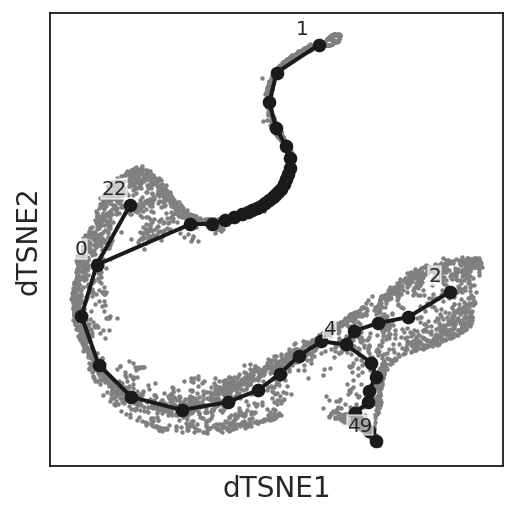

In [8]:
scf.pl.tree(adata,basis="dTSNE")

In [378]:
import cupy as cp
from scFates.tools.dist_tools_gpu import euclidean_mat_gpu, cor_mat_gpu
Tree=elpigraph.computeElasticPrincipalTree(X_t.T/100,NumNodes=50,
                                                   Do_PCA=False,
                                                   Lambda=0.02,
                                                   GPU=True)
R = euclidean_mat_gpu(cp.asarray(X_t/100),cp.asarray(Tree[0]["NodePositions"].T))
auto_sigma = round_base_10(np.max(np.abs(X_t.T/100)))/1000
R = (cp.exp(-R/auto_sigma))
R = (R.T/R.sum(axis=1)).T
R[cp.isnan(R)]=0

R=cp.asnumpy(R)
adata.uns["tree"]["R"]=R
print(auto_sigma)

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  4142  points and  3  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||50	0.0	50	49	44	2	0	0	0.0	0.0	0.9953	0.9958	0.0	0.0	0.0	0.0001	0


11.2416  seconds elapsed
0.0001


In [379]:
scf.pl.tree(adata,basis="dTSNE")

/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [388]:
round_base_10(np.max(np.abs(X_t.T*100)))

1000.0

In [387]:
np.max(np.abs(X_t.T)*100)

327.11303619783456

1.3033560588253277

In [7]:
import igraph
tree=adata.uns["tree"]


In [25]:
from elpigraph.plot import PartitionData, project_point_onto_graph
def project_on_tree(X, nodep,edges):
    partition, dists = PartitionData(
        X=X,
        NodePositions=nodep,
        MaxBlockSize=100000000,
        TrimmingRadius=np.inf,
        SquaredX=np.sum(X ** 2, axis=1, keepdims=1),
    )
    ProjStruct = project_point_onto_graph(
        X=X, NodePositions=nodep, Edges=edges, Partition=partition
    )
    # projval = ProjStruct['ProjectionValues']
    # edgeid = (ProjStruct['EdgeID']).astype(int)
    ProjStruct["Partition"] = partition
    return ProjStruct

In [34]:
def map_cells_epg(tree):
    g = igraph.Graph.Adjacency((tree["B"]>0).tolist(),mode="undirected")
    # Add edge weights and node labels.
    g.es['weight'] = tree["B"][tree["B"].nonzero()]
    proj_struct=project_on_tree(X_t.T,tree["F"].T,np.array(g.get_edgelist()))

    df=pd.DataFrame({"edge" : list(map(lambda eid: "|".join(proj_struct['Edges'][int(eid)].astype(str)),proj_struct["EdgeID"]))},
              index=adata.obs_names)
    
    trajs=extract_trajectories(tree["F"].T,np.array(g.get_edgelist()),tree["root"])
    def get_pst(traj):
        pst, traj_points=pseudo_time_trajectory(traj,proj_struct)
        return pd.Series(pst,index=traj_points)
    df["t"]=pd.concat(list(map(get_pst,trajs)),axis=1).apply(np.nanmean,axis=1).values

In [122]:
df=pd.DataFrame({"edge" : list(map(lambda eid: "|".join(proj_struct['Edges'][int(eid)].astype(str)),proj_struct["EdgeID"]))},
          index=adata.obs_names)
def get_pst(traj):
    pst, traj_points=pseudo_time_trajectory(traj,proj_struct)
    return pd.Series(pst,index=traj_points)
df["t"]=pd.concat(list(map(get_pst,trajs)),axis=1).apply(np.nanmean,axis=1).values

In [125]:
from elpigraph.plot import find_branches

In [221]:
segs=find_branches(g)["branches"]
segs_nonroot=tree["pp_seg"].loc[tree["pp_seg"].loc[:,"from"]!=tree["root"],["from","to"]]
for i in range(len(segs)):
    hit=segs_nonroot.apply(lambda x: all(np.isin(x,np.array(segs[i]))),axis=1)
    if any(segs_nonroot.apply(lambda x: all(np.isin(x,np.array(segs[i]))),axis=1)):    
        idx=np.argwhere(segs_nonroot.apply(lambda x: all(np.isin(x,np.array(segs[i]))),axis=1).values)[0][0]
        segs[i]=np.array(segs[i])[np.array(segs[i])!=segs_nonroot["from"].values[idx]].tolist()
        
np.argwhere(list(map(lambda s: np.sum(np.isin(s,np.array(df.edge[0].split("|"),dtype=int)))==2, segs)))[0][0]

In [230]:
df["seg"]=np.nan

In [298]:
proj_struct=project_on_tree(tree["F"].T,tree["F"].T,np.array(g.get_edgelist()))
trajs_N=extract_trajectories(tree["F"].T,np.array(g.get_edgelist()),tree["root"])
def get_pst(traj):
    pst, traj_points=pseudo_time_trajectory(traj,proj_struct)
    return pd.Series(pst,index=traj_points)
vals=pd.concat(list(map(get_pst,trajs_N)),axis=1).apply(np.nanmean,axis=1).values

In [306]:
vals

array([ 1., 25., 14.,  6., 10., 18.,  4., 23., 24., 11., 26.,  5., 15.,
        5.,  2., 23., 20., 17., 18.,  8., 19., 19.,  1., 14., 15., 10.,
       11., 12., 11., 10.,  9.,  7.,  4., 13.,  7.,  3.,  6.,  2.,  7.,
       17., 15., 18., 19., 12., 15., 16., 13.,  4., 14., 20.])

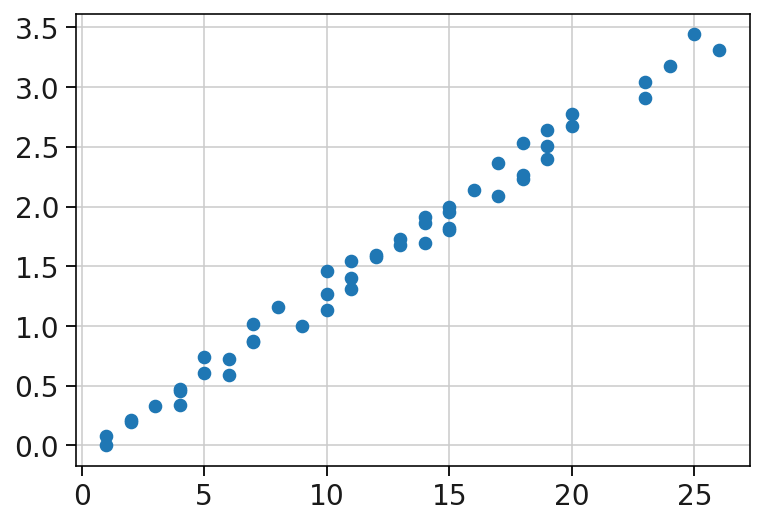

In [300]:
plt.scatter(vals,tree["pp_info"].time)

0     0.078055
1     3.441528
2     1.910666
3     0.727444
4     1.458379
5     2.535870
6     0.475078
7     3.045919
8     3.178015
9     1.310682
10    3.309055
11    0.740482
12    1.804134
13    0.607470
14    0.199630
15    2.912012
16    2.777295
17    2.366595
18    2.229381
19    1.162767
20    2.640463
21    2.401279
22    0.000000
23    1.693654
24    1.954490
25    1.269138
26    1.541988
27    1.592699
28    1.405328
29    1.133095
30    0.997336
31    1.016727
32    0.342725
33    1.725610
34    0.862552
35    0.327436
36    0.592598
37    0.209726
38    0.875764
39    2.091857
40    1.997986
41    2.268086
42    2.503397
43    1.579009
44    1.816713
45    2.134883
46    1.679224
47    0.458923
48    1.860078
49    2.671252
Name: time, dtype: float64

In [251]:
df.edge.values

array(['7|15', '0|22', '2|12', ..., '6|13', '19|31', '1|10'], dtype=object)

In [252]:
list(map(lambda eid: np.argwhere(list(map(lambda s: np.sum(np.isin(s,np.array(eid.split("|"),dtype=int)))==2, segs)))[0][0],df.edge.values.tolist()))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [272]:
tree["pp_info"]

PP      time seg
0    0  0.078055   3
1    1  3.441528   1
2    2  1.910666   4
3    3  0.727444   1
4    4  1.458379   5
5    5  2.535870   5
6    6  0.475078   2
7    7  3.045919   1
8    8  3.178015   1
9    9  1.310682   2
10  10  3.309055   1
11  11  0.740482   2
12  12  1.804134   4
13  13  0.607470   2
14  14  0.199630   1
15  15  2.912012   1
16  16  2.777295   1
17  17  2.366595   1
18  18  2.229381   1
19  19  1.162767   2
20  20  2.640463   1
21  21  2.401279   5
22  22  0.000000   3
23  23  1.693654   4
24  24  1.954490   1
25  25  1.269138   1
26  26  1.541988   1
27  27  1.592699   5
28  28  1.405328   1
29  29  1.133095   1
30  30  0.997336   1
31  31  1.016727   2
32  32  0.342725   2
33  33  1.725610   5
34  34  0.862552   1
35  35  0.327436   1
36  36  0.592598   1
37  37  0.209726   2
38  38  0.875764   2
39  39  2.091857   1
40  40  1.997986   5
41  41  2.268086   5
42  42  2.503397   1
43  43  1.579009   4
44  44  1.816713   1
45  45  2.134883   5
46  46  1.679224   1
47  47  0.458923   1
48  48  1.860078   5
49  49  2.671252   5

In [271]:
df

edge          t  seg
Run4_120703408880541   7|15  22.209365  NaN
Run4_120703409056541   0|22   1.000000  NaN
Run4_120703409580963   2|12  14.000000  NaN
Run4_120703423990708   2|12  14.000000  NaN
Run4_120703436876077   0|37   1.315999  NaN
...                     ...        ...  ...
Run5_241098904976174  11|13   5.070332  NaN
Run5_241106375007076   1|10  25.000000  NaN
Run5_241114577000174   6|13   4.396554  NaN
Run5_241114577004764  19|31   8.741792  NaN
Run5_241114589051630   1|10  25.000000  NaN

[4142 rows x 3 columns]

In [270]:
np.isin(segs[5],np.array(eid.split("|"),dtype=int))

IndexError: list index out of range

In [260]:
eid=df.edge[4]
np.argwhere(list(map(lambda s: np.sum(np.isin(s,np.array(eid.split("|"),dtype=int)))==2, segs)))[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [155]:
for c in 
np.any(np.isin(np.array(df.edge[0].split("|")).astype(int),segs[1]))

False

In [142]:
segs[1]

[0, 22]

In [61]:
from elpigraph.plot import PartitionData, project_point_onto_graph, pseudo_time_trajectory

In [57]:
def extract_trajectories(nodes_positions, edges, root_node, verbose=False):
    g = igraph.Graph()
    g.add_vertices(len(nodes_positions))
    g.add_edges(edges)
    degs = g.degree()
    leaf_nodes = [i for i, d in enumerate(degs) if d == 1]
    if verbose:
        print(len(leaf_nodes), "trajectories found")
    all_trajectories = []
    for lf in leaf_nodes:
        path_vertices = g.get_shortest_paths(root_node, to=lf, output="vpath")
        all_trajectories.append(path_vertices[0])
        path_edges = g.get_shortest_paths(root_node, to=lf, output="epath")
        if verbose:
            print("Vertices:", path_vertices)
            print("Edges:", path_edges)
        ped = []
        for ei in path_edges[0]:
            ped.append((g.get_edgelist()[ei][0], g.get_edgelist()[ei][1]))
        if verbose:
            print("Edges:", ped)
        # compute pseudotime along each path
    return all_trajectories

In [59]:
trajs=extract_trajectories(tree["F"].T,np.array(g.get_edgelist()),tree["root"])

In [111]:
adata.

4

array([22.20936489,  1.        , 14.        , ...,  4.39655372,
        8.74179195, 25.        ])

In [277]:
tree["pp_info"].time.max()

3.44152786191218

In [110]:
pd.Series(pst,index=traj_points)

1        1.000000
12       0.509641
24       1.000000
33       1.000000
42       1.000000
          ...    
4112    25.000000
4114    25.000000
4120    25.000000
4138    25.000000
4141    25.000000
Length: 1585, dtype: float64

In [117]:
adata.obs["t"]=pd.concat(list(map(get_pst,trajs)),axis=1).apply(np.nanmean,axis=1).values

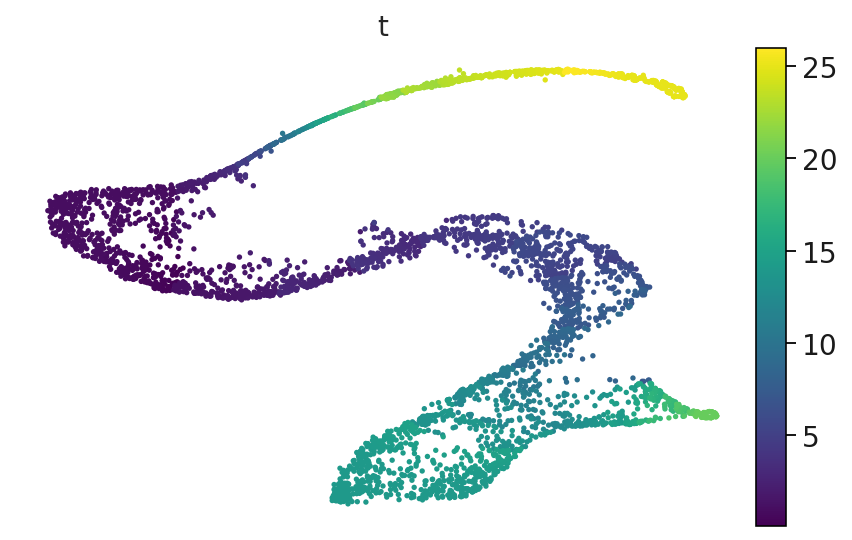

In [118]:
sc.pl.scatter(adata,basis="dTSNE",color="t",color_map="viridis")

In [5]:
scf.tl.tree(adata,method="epg",Nodes=50,use_rep="palantir",
            device="gpu",seed=1,epg_lambda = 0.02)

inferring a principal tree --> parameters used 
    50 principal points, mu = 0.1, lambda = 0.02
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  4142  points and  3  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||50	0.0271	50	49	44	2	0	0	0.0096	0.0086	0.9953	0.9958	0.0173	0.0002	0.0108	0.5413	0


10.8584  seconds elapsed
    finished (0:00:12) --> added 
    'epg', dictionnary containing inferred elastic tree generated from elpigraph (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment (

## Projecting the tree on the tsne computed from Palantir

In [38]:
%matplotlib inline
scf.pl.tree(adata,basis="dTSNE")

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


In [39]:
sc.pl.scatter(adata,color="CD34",basis="dTSNE",color_map="viridis")

## Selecting a root on the tree and projecting cells to obtain pseudotime value

In [41]:
scf.tl.root(adata,22)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)


In [44]:
scf.tl.pseudotime(adata)

projecting cells onto the principal tree
    finished (0:00:00) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)


In [52]:
adata.uns["tree"]["pp_seg"]

n from  to         d
1  1    0   1  3.363473
2  2    0   4  1.380324
3  3   22   0  0.078055
4  4    4   2  0.452287
5  5    4  49  1.212872

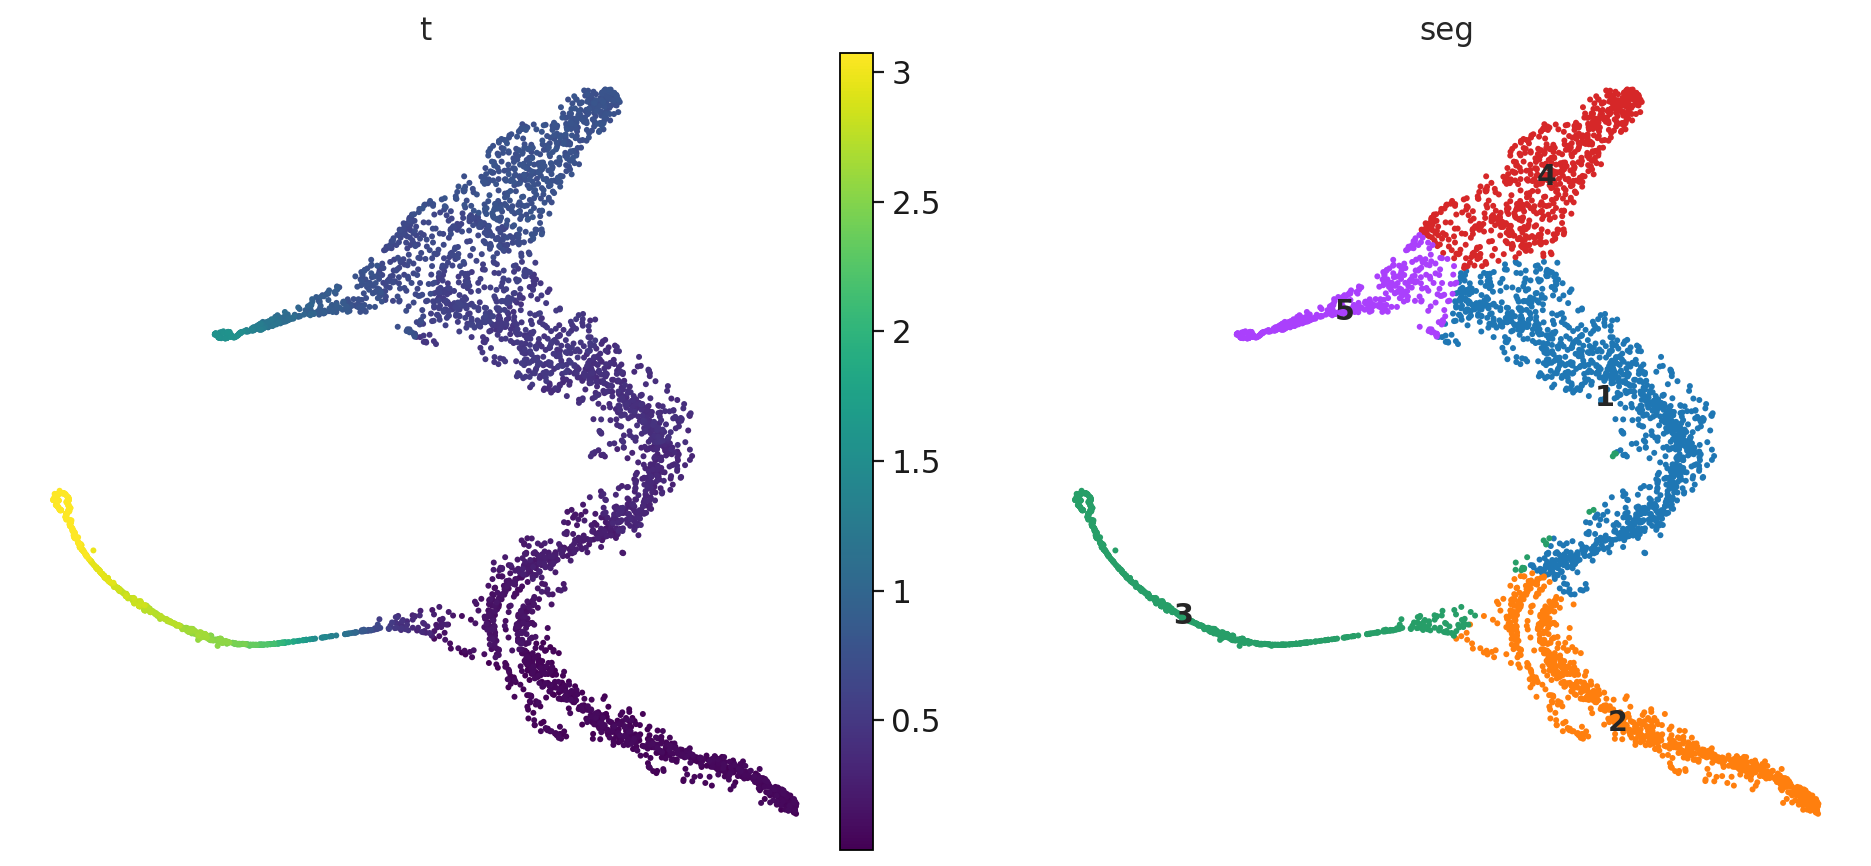

In [11]:
sc.pl.scatter(adata,basis="dTSNE", color=['t','seg'], legend_loc='on data',color_map="viridis")

## Test for associated features associated with the tree

In [12]:
sct.tl.test_association(adata,n_jobs=20)

test features for association with the tree
    mapping 0: 100%|██████████| 16106/16106 [05:36<00:00, 47.84it/s]
    found 3438 significant features (0:06:48) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)


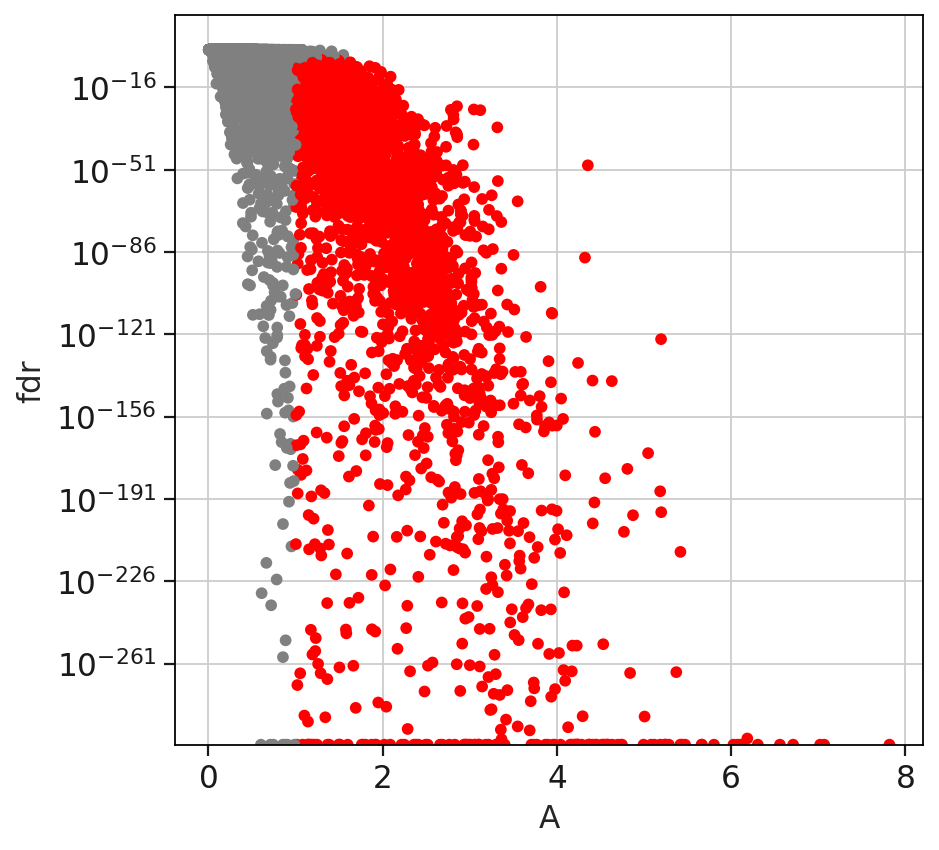

In [13]:
sct.pl.test_association(adata)

## Fit associated features

In [14]:
sct.tl.fit(adata,n_jobs=20)

fit features associated with the tree
    mapping 0:   1%|          | 40/3438 [00:01<02:06, 26.82it/s]

/home/lfaure/miniconda3/envs/gpu/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


    mapping 0: 100%|██████████| 3438/3438 [04:59<00:00, 11.49it/s]
    finished (0:05:10) --> added
    'tree/fit_list', list of fitted features on the tree for all mappings (adata.uns)
    'tree/fit_summary', summary of all fitted features on the tree for all mappings (adata.uns)


## Cluster and plot fitted features

In [15]:
sct.tl.cluster(adata,knn=100)

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 7.285085916519165 seconds
Jaccard graph constructed in 2.8362033367156982 seconds
Wrote graph to binary file in 1.2869925498962402 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.720795
After 3 runs, maximum modularity is Q = 0.725139
Louvain completed 23 runs in 4.416988372802734 seconds
PhenoGraph complete in 16.01350736618042 seconds
    finished (0:00:17) --> added
    'tree/fit_clusters', cluster assignments for features (adata.uns)


In [16]:
pd.Series(adata.uns["tree"]["fit_clusters"]).unique()

array([8, 6, 2, 0, 7, 4, 1, 5, 3])

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


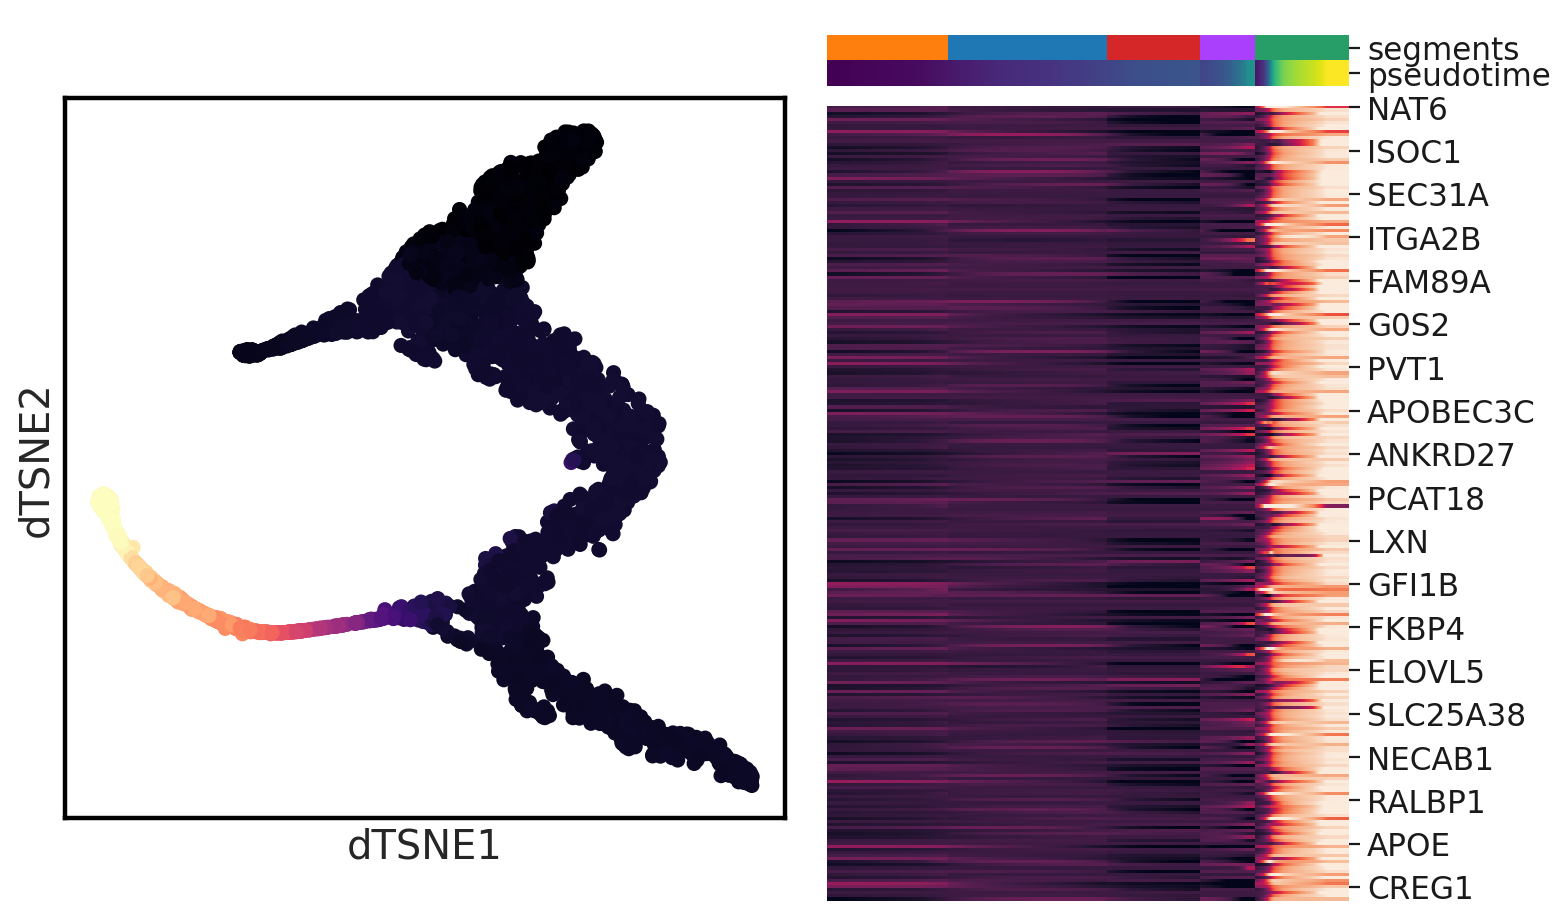

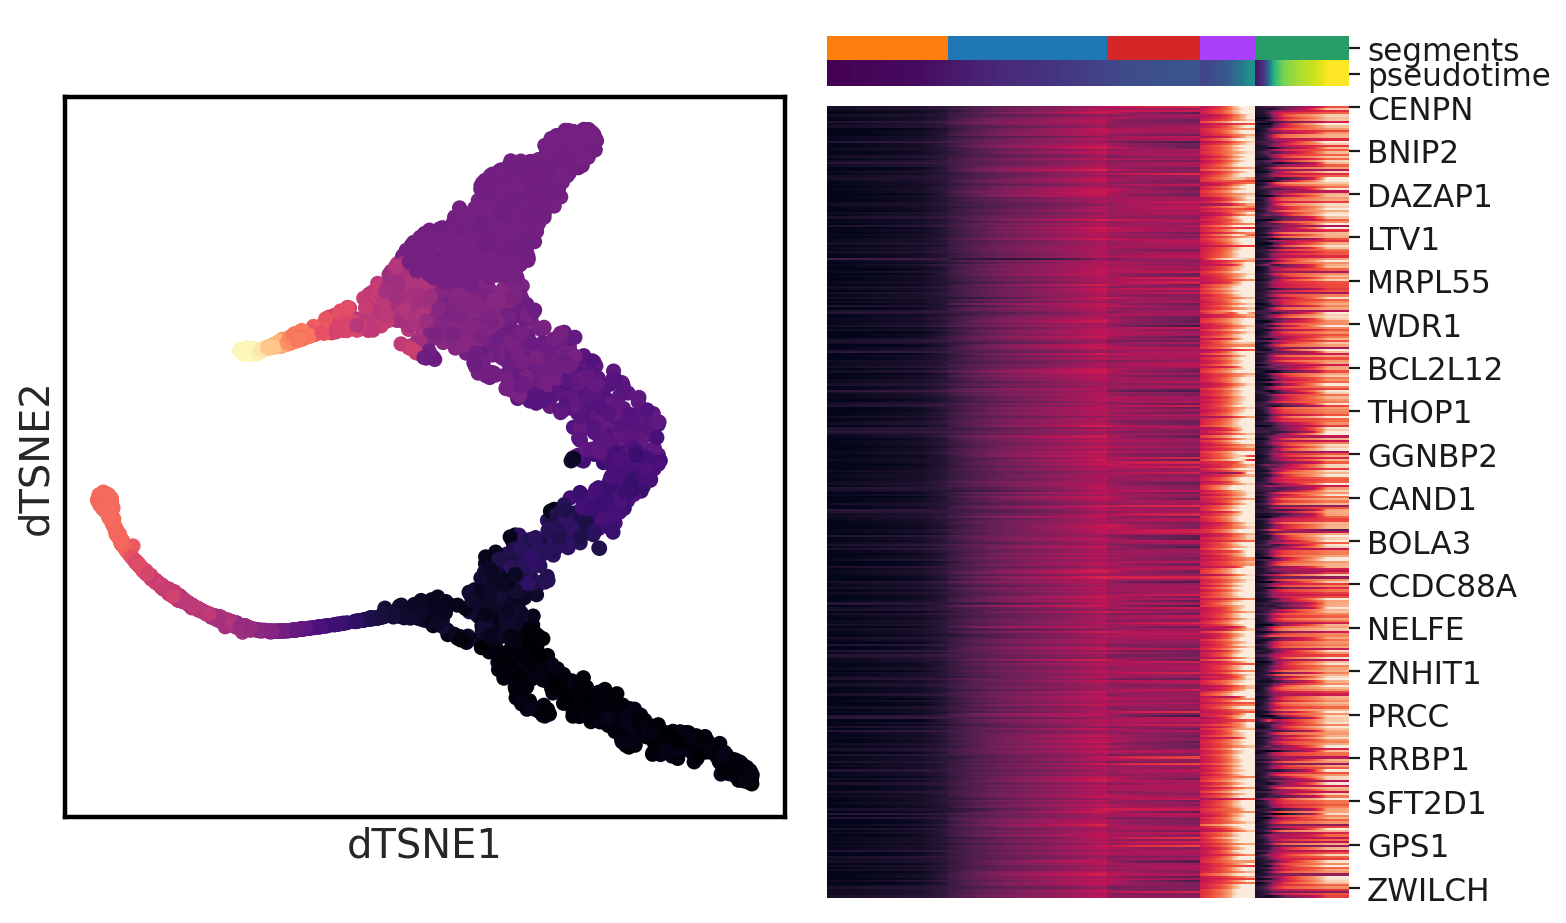

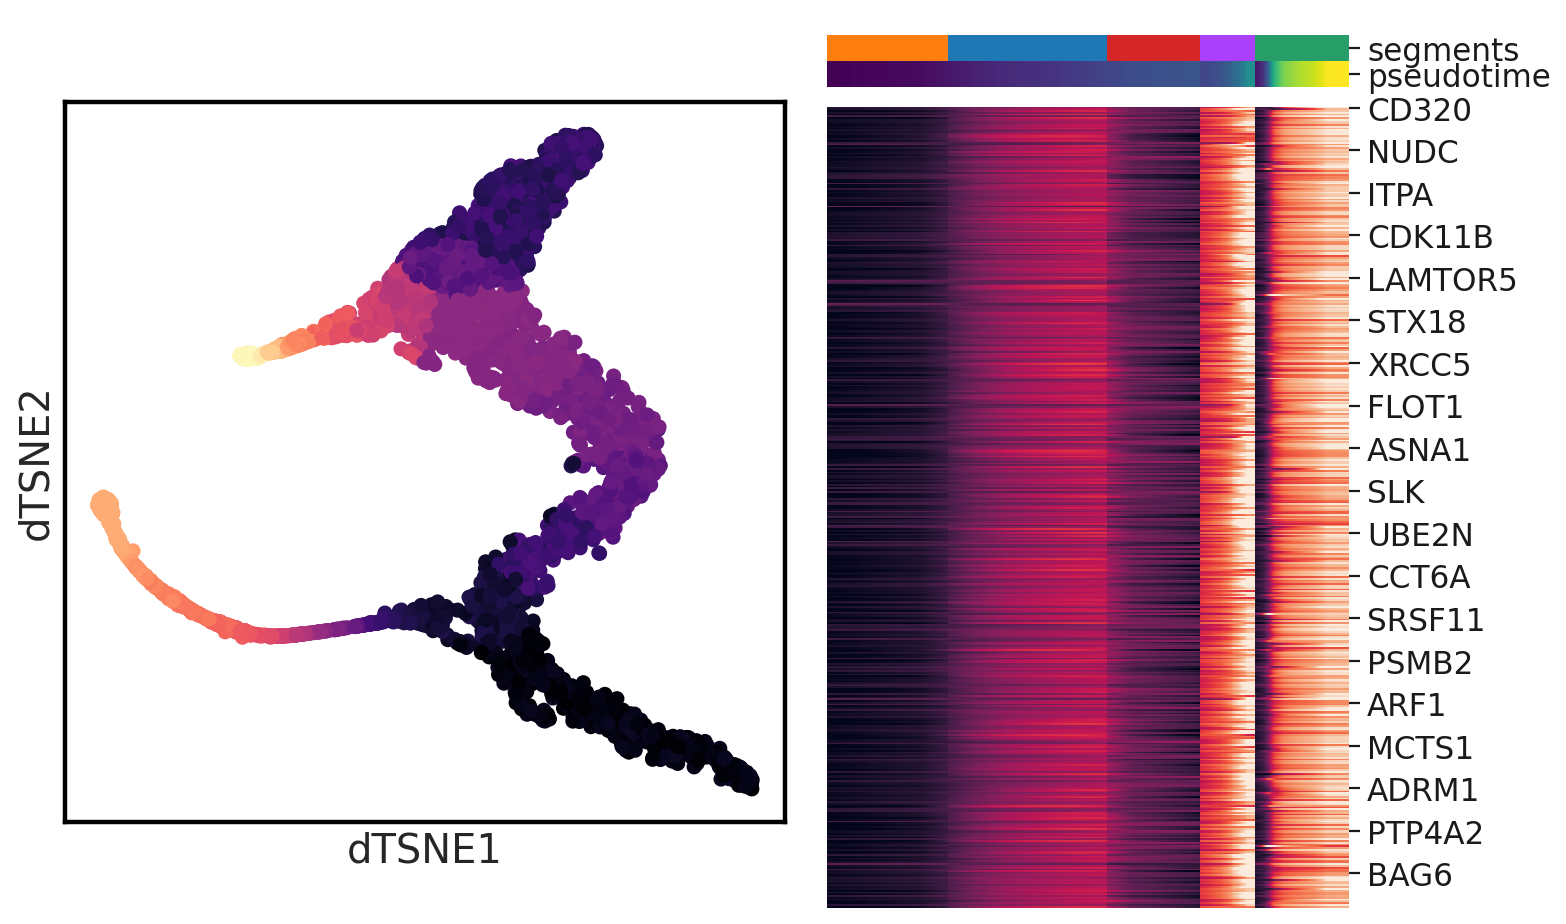

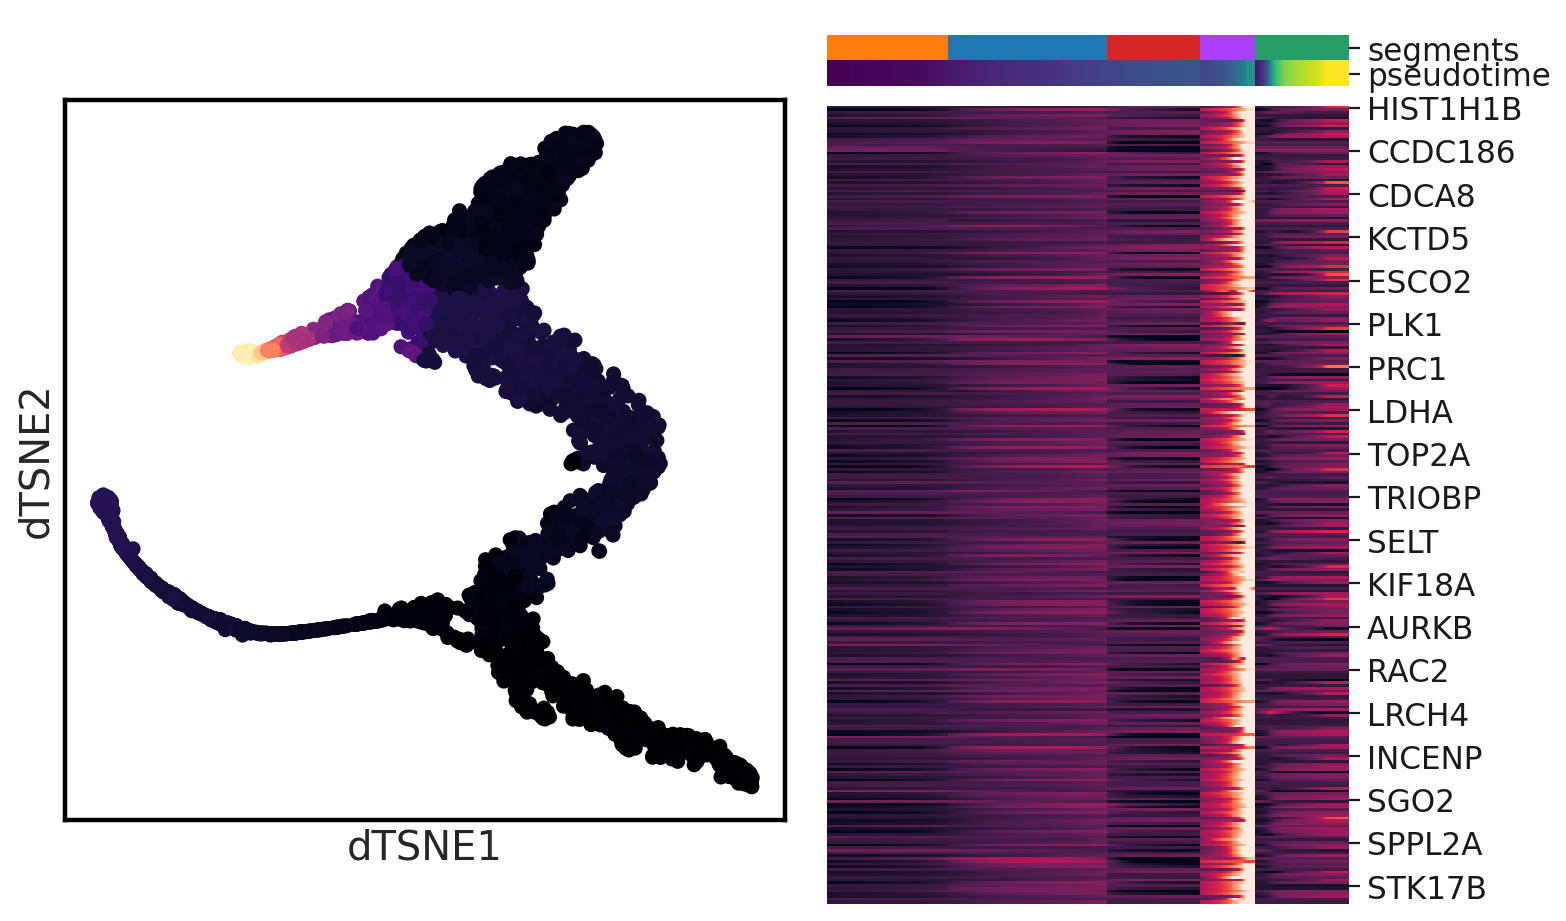

In [17]:
import matplotlib.pyplot as plt
for c in pd.Series(adata.uns["tree"]["fit_clusters"]).unique():
    sct.pl.cluster(adata,clu=c,basis="dTSNE",figsize=(10,6))